In [1]:
#Import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest, AdaBoostClassifier
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [2]:
# Load dataset
df = pd.read_csv("creditcard.csv")

# Features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Normalize Amount
scaler = MinMaxScaler()
X["Amount"] = scaler.fit_transform(X[["Amount"]])

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


C:\Users\HP\AppData\Local\Temp\ipykernel_8316\2267879667.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

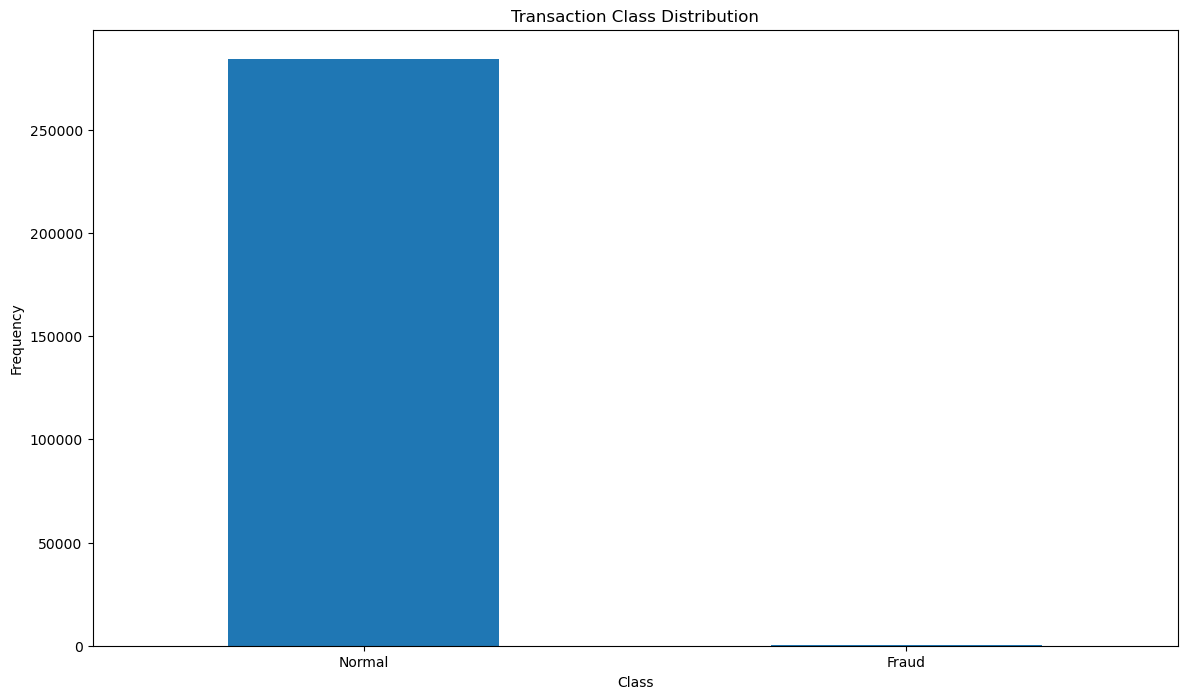

In [4]:
count_classes = pd.value_counts(df['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [5]:
# Convert Time into hours
X["Hour"] = (X["Time"] / 3600) % 24
X = X.drop("Time", axis=1)

# Handle imbalance: SMOTE + Undersampling
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X, y)

In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, stratify=y_res, random_state=42
)


In [7]:
# Models
models = {
    "LOF": LocalOutlierFactor(n_neighbors=20, novelty=True),
    "IsolationForest": IsolationForest(n_estimators=100, contamination=0.001, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=10, eval_metric="logloss", use_label_encoder=False),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42)
}


In [8]:

# Train and Evaluate
results = {}
for name, model in models.items():
    if name == "LOF":
        model.fit(X_train)
        y_pred = model.predict(X_test)
        y_pred = np.where(y_pred == -1, 1, 0)  # LOF: -1 anomaly, 1 normal
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1": report['1']['f1-score'],
        "ROC-AUC": roc_auc_score(y_test, y_pred)
    }

# Display Results
results_df = pd.DataFrame(results).T
print(results_df)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `

                 Precision    Recall        F1   ROC-AUC
LOF               0.534694  0.092156  0.157216  0.526030
IsolationForest   0.332486  0.996248  0.498577  0.498124
XGBoost           0.995797  1.000000  0.997894  0.998945
AdaBoost          0.982173  0.968930  0.975506  0.980068


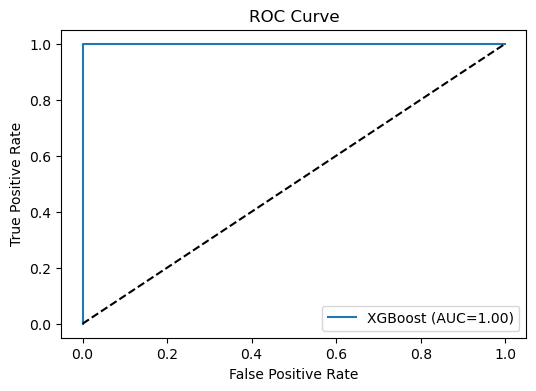

In [9]:
# Plot ROC curve for XGBoost as example
from sklearn.metrics import roc_curve
y_prob = models["XGBoost"].predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


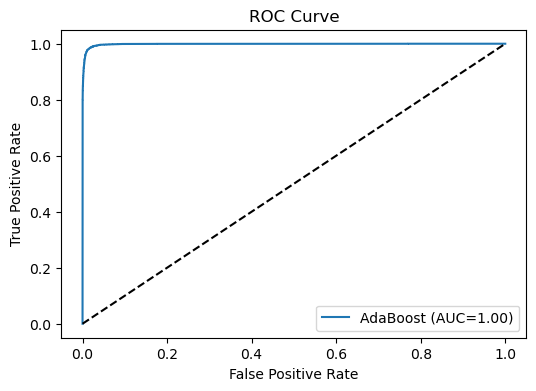

In [10]:
 #Plot ROC curve for XGBoost as example
from sklearn.metrics import roc_curve
y_prob = models["AdaBoost"].predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AdaBoost (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
